# Experiment Management with Aim

This tutorial is based on a [tutorial](https://github.com/osoblanco/tutorials/blob/master/3d_segmentation/spleen_segmentation_3d.ipynb) developed by the Aim team for MONAI, along with a blog post [here](https://aimstack.io/aim-monai-tutorial/).

This tutorial shows how to use common Aim functionalities to management MONAI experiments. The MONAI example used here is [3D spleen segmentation](https://github.com/Project-MONAI/tutorials/blob/main/3d_segmentation/spleen_segmentation_3d.ipynb).

![spleen](http://medicaldecathlon.com/img/spleen0.png)

Target: Spleen  
Modality: CT  
Size: 61 3D volumes (41 Training + 20 Testing)  
Source: Memorial Sloan Kettering Cancer Center  
Challenge: Large ranging foreground size

## Setup environment

We use `plotly` to generate interactive 3D visualizations, and we include relevant code below. You can find official documentations [here](https://plotly.com/python/). You are welcome to remove it if it's not desired, or replace it with your own preferred method of visualization. 

Note that Aim also has an `Image` class that renders the visualizations in its UI; you can find its usage in the code below.

In [ ]:
!python -c "import monai" || pip install -q "monai-weekly[gdown, nibabel, tqdm, ignite]"
!python -c "import matplotlib" || pip install -q matplotlib
!python -c "import plotly" || pip install plotly==5.9.0
!python -c "import aim" || pip install aim
%matplotlib inline

In [ ]:
import resource
from monai.utils import first, set_determinism
from monai.transforms import (
    AsDiscrete,
    EnsureChannelFirstd,
    Compose,
    CropForegroundd,
    LoadImaged,
    Orientationd,
    RandCropByPosNegLabeld,
    ScaleIntensityRanged,
    Spacingd,
)
from monai.networks.nets import UNet
from monai.networks.layers import Norm
from monai.metrics import DiceMetric
from monai.losses import DiceLoss
from monai.inferers import sliding_window_inference
from monai.data import CacheDataset, DataLoader, Dataset, decollate_batch
from monai.config import print_config
from monai.apps import download_and_extract
import torch
import matplotlib.pyplot as plt
import tempfile
import shutil
import os
import glob

import numpy as np
import math
import plotly.graph_objects as go
import aim

## Setup imports

In [ ]:
# Copyright 2020 MONAI Consortium
# Licensed under the Apache License, Version 2.0 (the "License");
# you may not use this file except in compliance with the License.
# You may obtain a copy of the License at
#     http://www.apache.org/licenses/LICENSE-2.0
# Unless required by applicable law or agreed to in writing, software
# distributed under the License is distributed on an "AS IS" BASIS,
# WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.
# See the License for the specific language governing permissions and
# limitations under the License.


print_config()

## Setup data directory

You can specify a directory with the `MONAI_DATA_DIRECTORY` environment variable.  
This allows you to save results and reuse downloads.  
If not specified a temporary directory will be used.

In [ ]:
directory = os.environ.get("MONAI_DATA_DIRECTORY")
root_dir = tempfile.mkdtemp() if directory is None else directory
print(root_dir)

## Download dataset

Downloads and extracts the dataset.  
The dataset comes from http://medicaldecathlon.com/.

In [ ]:
resource_link = "https://msd-for-monai.s3-us-west-2.amazonaws.com/Task09_Spleen.tar"
md5 = "410d4a301da4e5b2f6f86ec3ddba524e"

compressed_file = os.path.join(root_dir, "Task09_Spleen.tar")
data_dir = os.path.join(root_dir, "Task09_Spleen")
if not os.path.exists(data_dir):
    download_and_extract(resource_link, compressed_file, root_dir, md5)

## Set MSD Spleen dataset path

In [ ]:
train_images = sorted(
    glob.glob(os.path.join(data_dir, "imagesTr", "*.nii.gz")))
train_labels = sorted(
    glob.glob(os.path.join(data_dir, "labelsTr", "*.nii.gz")))
data_dicts = [
    {"image": image_name, "label": label_name}
    for image_name, label_name in zip(train_images, train_labels)
]
train_files, val_files = data_dicts[:-9], data_dicts[-9:]

## Set up Aim tracking

You can specify an experiment name here; use a new experiment name to prevent conflation of tracking outputs form multiple runs.

For ease of use, we set up tracking locally.

**IMPORTANT: If (and only if) this is your first time tracking in this folder, run `aim init` in the terminal.**

There is an option to track remotely, and we provide an example below. You can find more complete and up-to-date documentation on remote tracking [here](https://aimstack.readthedocs.io/en/latest/using/remote_tracking.html).

Aim supports tracking a wide variety of information. Here, we provide examples for tracking UNet model arguments, loss and Dice metrics, 2D and 3D visualizations, output log, and system information like CPU usage (automatic). With custom functions, you can record more detailed and systematic information of the neural network, model graph, transforms, and more; check out this [tutorial](https://github.com/osoblanco/tutorials/blob/master/3d_segmentation/spleen_segmentation_3d.ipynb) from the Aim team for more information.

In [ ]:
# IMPORTANT: if this is your first time tracking in this folder, you need to run aim init
# !aim init

experiment_name = 'spleen_segmentation_3d_9'
track_locally = True

if track_locally:
    aim_run = aim.Run(experiment=experiment_name)
else:
    remote_tracking_server = 'aim://0.0.0.0:53800'
    aim_run = aim.Run(experiment=experiment_name, repo=remote_tracking_server)

## Set deterministic training for reproducibility

In [ ]:
set_determinism(seed=0)

## Setup transforms for training and validation

In [ ]:
train_transforms = Compose(
    [
        LoadImaged(keys=["image", "label"]),
        EnsureChannelFirstd(keys=["image", "label"]),
        Orientationd(keys=["image", "label"], axcodes="RAS"),
        Spacingd(keys=["image", "label"], pixdim=(
            1.5, 1.5, 2.0), mode=("bilinear", "nearest")),
        ScaleIntensityRanged(
            keys=["image"], a_min=-57, a_max=164,
            b_min=0.0, b_max=1.0, clip=True,
        ),
        CropForegroundd(keys=["image", "label"], source_key="image"),
        RandCropByPosNegLabeld(
            keys=["image", "label"],
            label_key="label",
            spatial_size=(96, 96, 96),
            pos=1,
            neg=1,
            num_samples=4,
            image_key="image",
            image_threshold=0,
        ),
        # user can also add other random transforms
        # RandAffined(
        #     keys=['image', 'label'],
        #     mode=('bilinear', 'nearest'),
        #     prob=1.0, spatial_size=(96, 96, 96),
        #     rotate_range=(0, 0, np.pi/15),
        #     scale_range=(0.1, 0.1, 0.1)),
    ]
)
val_transforms = Compose(
    [
        LoadImaged(keys=["image", "label"]),
        EnsureChannelFirstd(keys=["image", "label"]),
        Orientationd(keys=["image", "label"], axcodes="RAS"),
        Spacingd(keys=["image", "label"], pixdim=(
            1.5, 1.5, 2.0), mode=("bilinear", "nearest")),
        ScaleIntensityRanged(
            keys=["image"], a_min=-57, a_max=164,
            b_min=0.0, b_max=1.0, clip=True,
        ),
        CropForegroundd(keys=["image", "label"], source_key="image"),
    ]
)

## Sample visualization to be included in Aim

This cell is needed and only needed for plotly visualizations. It contains some helper functions. If you run this cell, you will see an example of what the 3D visualizations look like.

If you get a shape mismatch error, it may have to do with the size of your image. Changing `number_of_frames` (size of the dimension 0) in `plotly_3d_figure` might solve the problem.

Here is a sample visualization with Plotly. It is an interactive visualization where you can drag the slider to view different slices of the same scan.
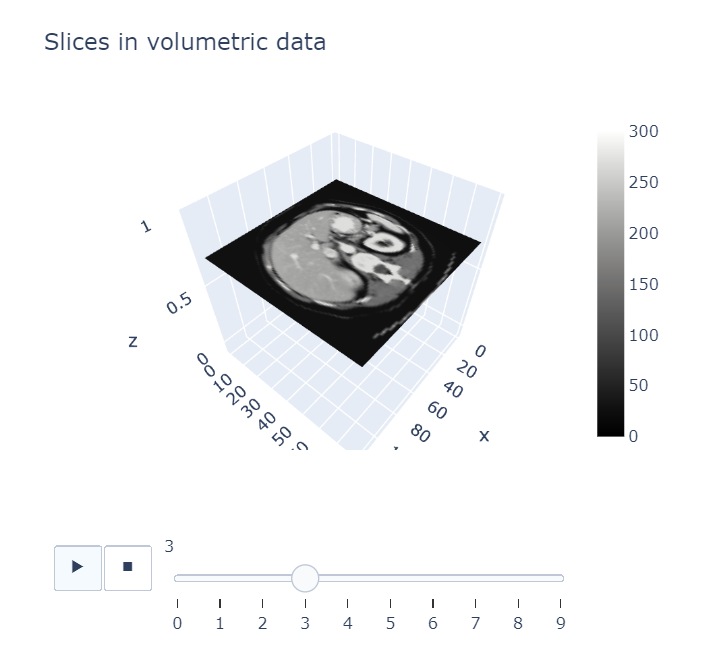

In [ ]:
def bin_ndarray(ndarray, new_shape, operation='mean'):
    """
    Bins an ndarray in all axes based on the target shape, by summing or
        averaging.
    Number of output dimensions must match number of input dimensions.
    Example
    -------
    >>> m = np.arange(0,100,1).reshape((10,10))
    >>> n = bin_ndarray(m, new_shape=(5,5), operation='sum')
    >>> print(n)
    [[ 22  30  38  46  54]
     [102 110 118 126 134]
     [182 190 198 206 214]
     [262 270 278 286 294]
     [342 350 358 366 374]]
    """
    if not operation.lower() in ['sum', 'mean', 'average', 'avg']:
        raise ValueError("Operation {} not supported.".format(operation))
    if ndarray.ndim != len(new_shape):
        raise ValueError("Shape mismatch: {} -> {}".format(ndarray.shape,
                                                           new_shape))
    compression_pairs = [(d, c // d) for d, c in zip(new_shape,
                                                     ndarray.shape)]
    flattened = [num for p in compression_pairs for num in p]
    ndarray = ndarray.reshape(flattened)
    for i in range(len(new_shape)):
        if operation.lower() == "sum":
            ndarray = ndarray.sum(-1 * (i + 1))
        elif operation.lower() in ["mean", "average", "avg"]:
            ndarray = ndarray.mean(-1 * (i + 1))
    return ndarray


def closest_shapes_up(shapes, dims, pad_factor=10):
    new_shape = [shapes[i] for i in range(len(shapes))]
    for dim in dims:
        new_shape[dim] = closest_number_up(shapes[dim], pad_factor)

    return new_shape


def closest_number_up(n, m):
    # Find the quotient
    q = int(n / m)

    if (n * m) > 0:
        closest_up = (m * (q + 1))
    else:
        closest_up = (m * (q - 1))

    return closest_up


def pad_ndarray(ndarray, new_shape):
    result = np.zeros(new_shape)
    result[:ndarray.shape[0], :ndarray.shape[1], :ndarray.shape[2]] = ndarray
    return result


def frame_args(duration):
    return {
        "frame": {"duration": duration},
        "mode": "immediate",
        "fromcurrent": True,
        "transition": {"duration": duration, "easing": "linear"},
    }


def plotly_3d_figure(volume, number_of_frames, sampling_rate=2, padding_factor=10):
    volume = (volume.T * 255).float()
    nb_frames = number_of_frames
    frame_ratio = nb_frames / 10

    original_frames = len(volume)
    frame_subsample_rate = math.ceil(original_frames / nb_frames)

    volume = volume[::frame_subsample_rate]

    pad_shape = closest_shapes_up(volume.shape, dims=(1, 2), pad_factor=padding_factor)
    volume = pad_ndarray(volume, pad_shape)
    r, c = volume[0].shape
    volume = bin_ndarray(volume, (nb_frames, int(r / sampling_rate), int(c / sampling_rate)))
    r, c = volume[0].shape

    fig = go.Figure(frames=[go.Frame(data=go.Surface(
        z=(frame_ratio - k * 0.1) * np.ones((r, c)),
        surfacecolor=np.flipud(volume[nb_frames - 1 - k]),
        cmin=0, cmax=300
    ),
        name=str(k)  # you need to name the frame for the animation to behave properly
    )
        for k in range(nb_frames)])

    # Add data to be displayed before animation starts
    fig.add_trace(go.Surface(
        z=frame_ratio * np.ones((r, c)),
        surfacecolor=np.flipud(volume[nb_frames - 1]),
        colorscale='Gray',
        cmin=0, cmax=300,
        colorbar=dict(thickness=20, ticklen=4)
    ))

    sliders = [
        {
            "pad": {"b": 10, "t": 60},
            "len": 0.9,
            "x": 0.1,
            "y": 0,
            "steps": [
                {
                    "args": [[f.name], frame_args(0)],
                    "label": str(k),
                    "method": "animate",
                }
                for k, f in enumerate(fig.frames)
            ],
        }
    ]

    # Layout
    fig.update_layout(
        title='Slices in volumetric data',
        width=500,
        height=500,
        scene=dict(
            zaxis=dict(range=[-0.1, frame_ratio], autorange=False),
            aspectmode='auto',
            aspectratio=dict(x=1, y=1, z=1),
        ),
        updatemenus=[
            {
                "buttons": [
                    {
                        "args": [None, frame_args(1)],
                        "label": "&#9654;",  # play symbol
                        "method": "animate",
                    },
                    {
                        "args": [[None], frame_args(0)],
                        "label": "&#9724;",  # pause symbol
                        "method": "animate",
                    },
                ],
                "direction": "left",
                "pad": {"r": 10, "t": 70},
                "type": "buttons",
                "x": 0.1,
                "y": 0,
            }
        ],
        sliders=sliders
    )

    return fig

In [ ]:
check_ds = Dataset(data=val_files, transform=val_transforms)
check_loader = DataLoader(check_ds, batch_size=1)
check_data = first(check_loader)
vol = check_data["image"][0][0]
fig = plotly_3d_figure(vol, number_of_frames=10, sampling_rate=2)
fig.show()

## Define CacheDataset and DataLoader for training and validation

In [ ]:
train_ds = CacheDataset(
    data=train_files, transform=train_transforms,
    cache_rate=1.0, num_workers=4)
train_loader = DataLoader(train_ds, batch_size=2, shuffle=True, num_workers=4)

val_ds = CacheDataset(
    data=val_files, transform=val_transforms, cache_rate=1.0, num_workers=4)
val_loader = DataLoader(val_ds, batch_size=1, num_workers=4)

In [ ]:
rlimit = resource.getrlimit(resource.RLIMIT_NOFILE)
resource.setrlimit(resource.RLIMIT_NOFILE, (4096, rlimit[1]))

## Create Model, Loss, Optimizer

In [ ]:
UNet_metadata = dict(spatial_dims=3,
                     in_channels=1,
                     out_channels=2,
                     channels=(16, 32, 64, 128, 256),
                     strides=(2, 2, 2, 2),
                     num_res_units=2,
                     norm=Norm.BATCH)

In [ ]:
# standard PyTorch program style: create UNet, DiceLoss and Adam optimizer
device = torch.device("cuda:0")
model = UNet(**UNet_metadata).to(device)
loss_function = DiceLoss(to_onehot_y=True, softmax=True)
loss_type = "DiceLoss"
optimizer = torch.optim.Adam(model.parameters(), 1e-4)
dice_metric = DiceMetric(include_background=False, reduction="mean")

In [ ]:
aim_run['UNet_metadata'] = UNet_metadata

Optimizer_metadata = {}
for ind, param_group in enumerate(optimizer.param_groups):
    optim_meta_keys = list(param_group.keys())
    Optimizer_metadata[f'param_group_{ind}'] = {key: value for (
        key, value) in param_group.items() if 'params' not in key}
aim_run['Optimizer_metadata'] = Optimizer_metadata

## Train with tracking

At this point, you can open up the Aim UI to visualize results. For best results, open a terminal in the same folder and environment and run `aim up &`, then follow the link (e.g., `http://127.0.0.1:43800`) to see the Aim interface. Note that the run does not have to be ended for you to open the UI; Aim supports live updates as well. If you get an error saying "address already in use," you may have attempted to open up Aim multiple times. In that case, you can specify a different port number using `aim up --port xxxxx &`.

A sample user interface looks like this:
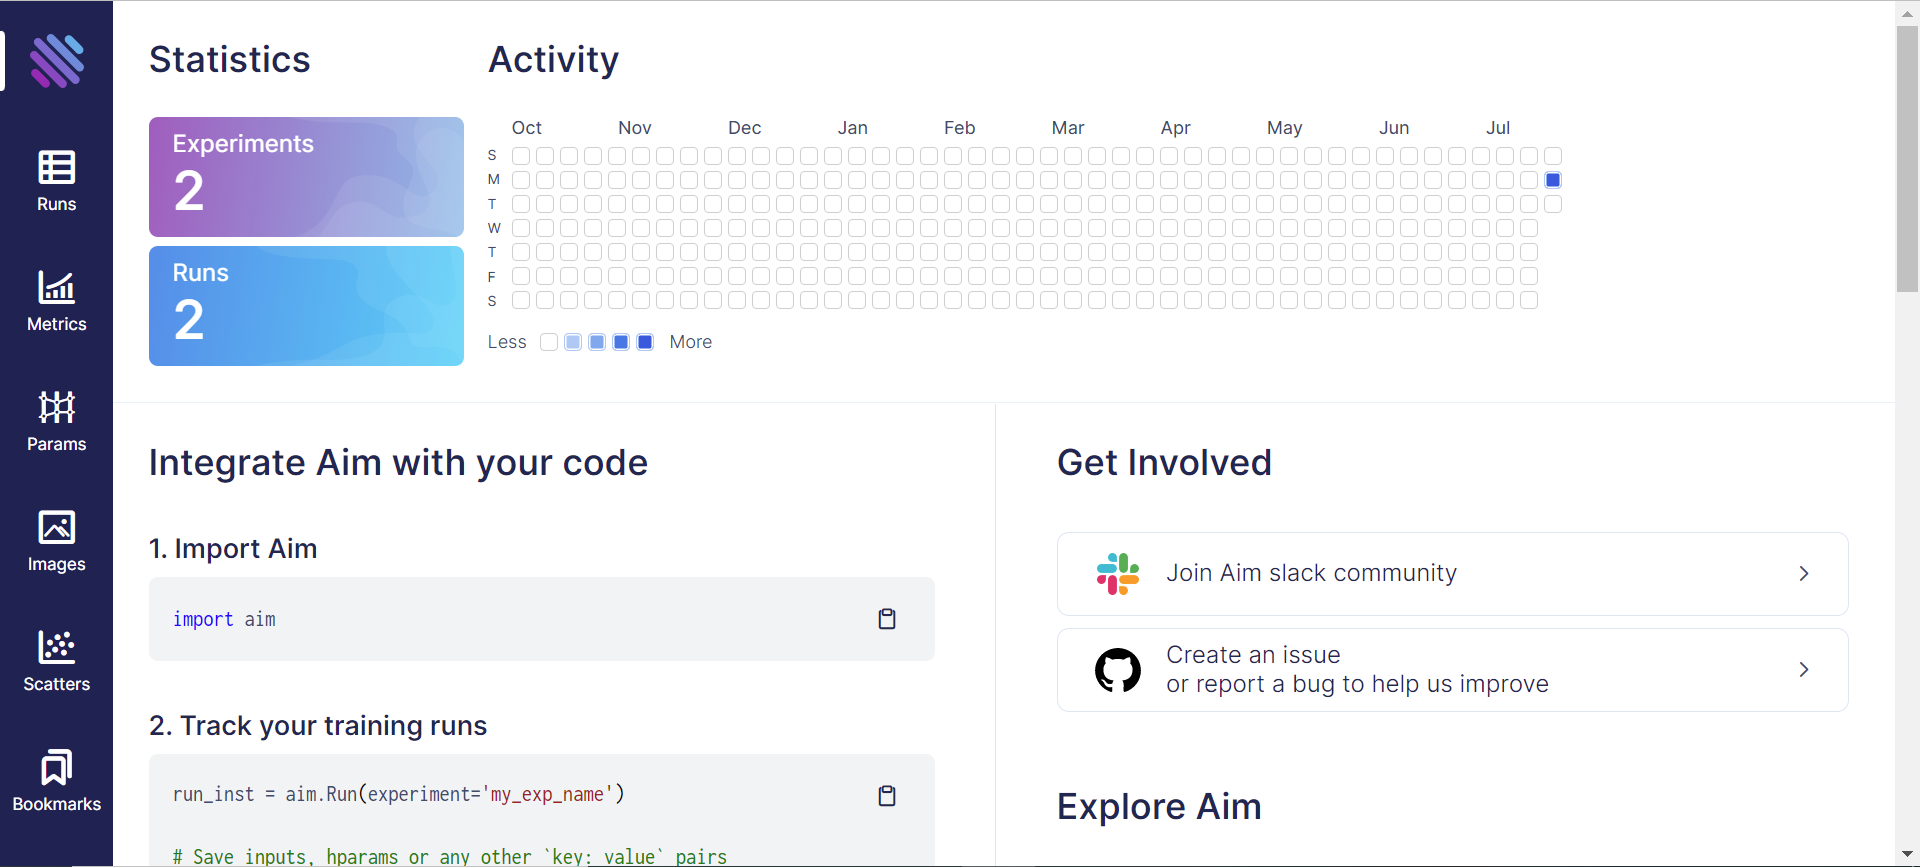

Click on "Runs" in the left to see a summary of all experiments. Note that experiments can have the same name:
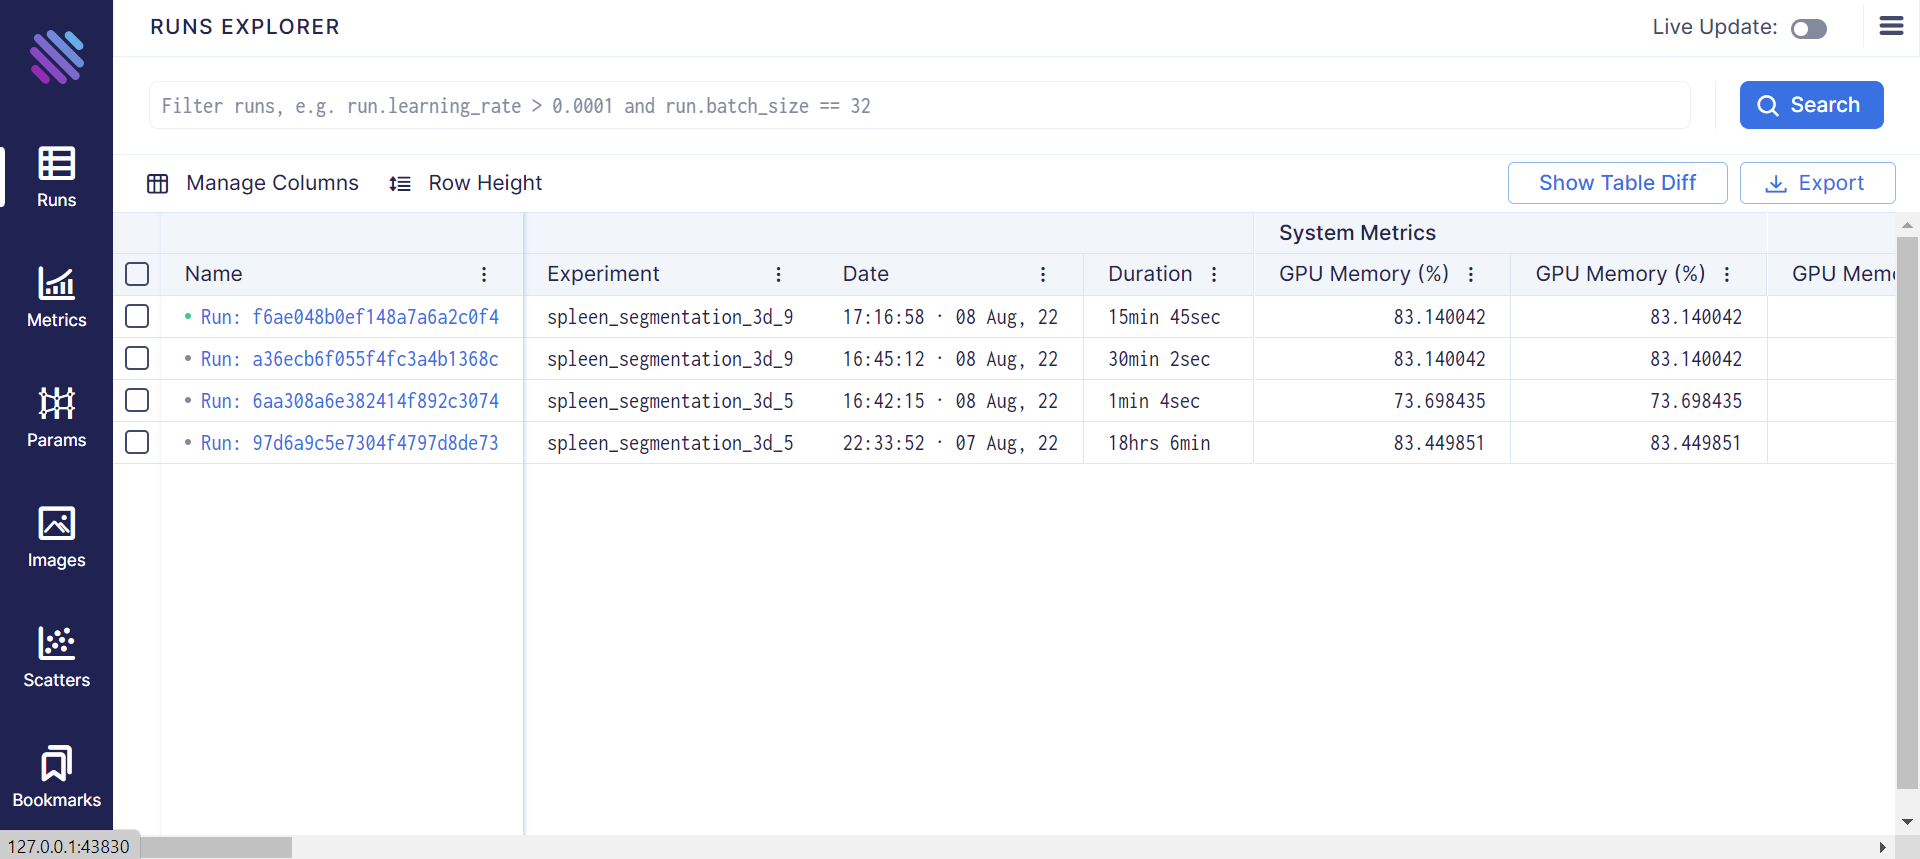

Click on a hyperlink under "Name" to see comprehensive information about that experiment, where you can explore all types of information that you have chosen to track. Note that in our tutorial, 2D visualizations are under "Images," while 3D visualizations are under "Figures."
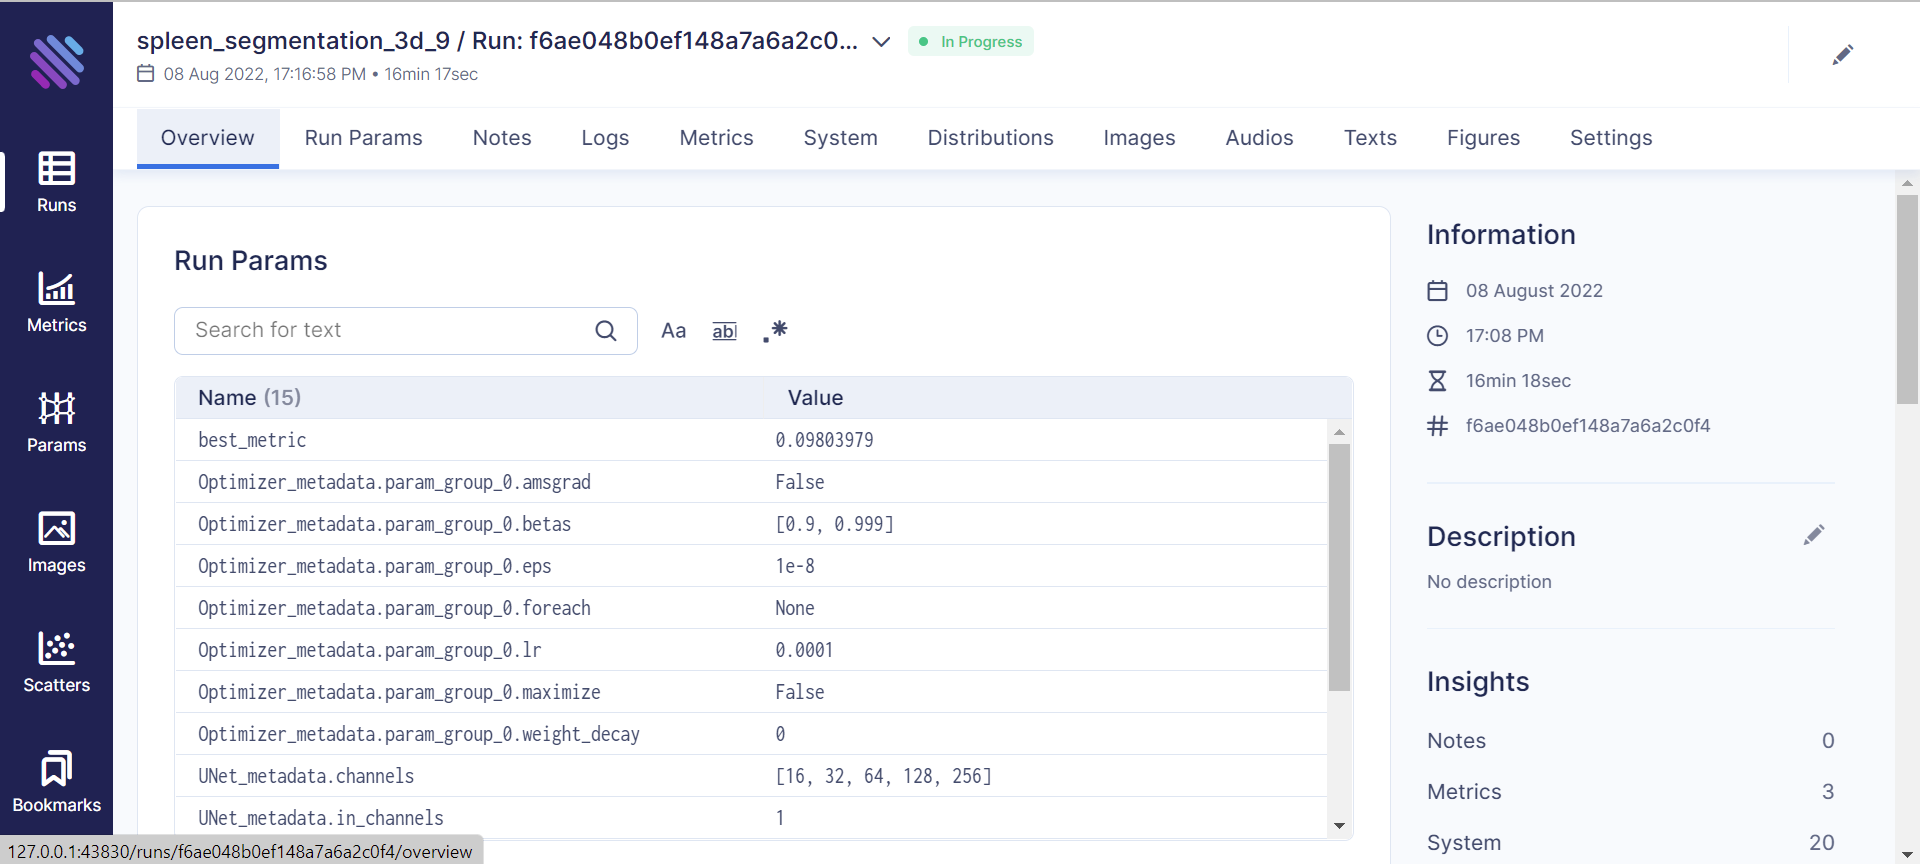

The other tabs on the left ("Metrics", "Params", "Images", "Scatters") allow you to make custom graphs visualizing different combinations of information.

Note that the 3D plotly visualizations can take up a non-trivial amount of disc space and use a non-trivial amount of time. If you only want the final result, set `save_3d_interval` equal to `max_epochs`. 

We have placed saving 3D visualizations within validation for now, so `save_3d_interval` also needs to be divisible by `val_interval`, but you can customize its usage to your needs.

In [ ]:
# the original segmentation was run with 600 steps; to see a quick example, use 10 steps
max_epochs = 10
val_interval = 2
# use this to specify how often you want to save 3D visualizations
save_3d_interval = 4

best_metric = -1
best_metric_epoch = -1
epoch_loss_values = []
metric_values = []
post_pred = Compose([AsDiscrete(argmax=True, to_onehot=2)])
post_label = Compose([AsDiscrete(to_onehot=2)])

slice_to_track = 80

for epoch in range(max_epochs):
    print("-" * 10)
    print(f"epoch {epoch + 1}/{max_epochs}")
    model.train()
    epoch_loss = 0
    step = 0
    for batch_data in train_loader:
        step += 1
        inputs, labels = (
            batch_data["image"].to(device),
            batch_data["label"].to(device),
        )
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = loss_function(outputs, labels)
        loss.backward()
        optimizer.step()
        epoch_loss += loss.item()
        print(
            f"{step}/{len(train_ds) // train_loader.batch_size}, "
            f"train_loss: {loss.item():.4f}")
        aim_run.track(loss.item(), name="Batch_Loss", context={'type': loss_type})

    epoch_loss /= step
    epoch_loss_values.append(epoch_loss)
    print(f"epoch {epoch + 1} average loss: {epoch_loss:.4f}")

    aim_run.track(epoch_loss, name="Epoch_Loss", context={'type': loss_type})

    if (epoch + 1) % val_interval == 0:
        model.eval()
        with torch.no_grad():
            tracked_2d = False
            for index, val_data in enumerate(val_loader):
                val_inputs, val_labels = (
                    val_data["image"].to(device),
                    val_data["label"].to(device),
                )
                roi_size = (160, 160, 160)
                sw_batch_size = 4
                val_outputs = sliding_window_inference(
                    val_inputs, roi_size, sw_batch_size, model)

                if not tracked_2d:
                    output = torch.argmax(val_outputs, dim=1)[0, :, :, slice_to_track].float()
                    aim_run.track(aim.Image(output, caption=f'Predicted Label: {index}'),
                                  name='Predictions', context={'type': 'labels'})
                    aim_run.track(aim.Image(val_inputs[0, 0, :, :, slice_to_track],
                                            caption=f'Input Image: {index}'),
                                  name='Validation', context={'type': 'Input'})
                    aim_run.track(aim.Image(val_labels[0, 0, :, :, slice_to_track],
                                            caption=f'Label Image: {index}'),
                                  name='Validation', context={'type': 'Label'})
                    print("tracked images")
                    tracked_2d = True

                val_outputs = [post_pred(i) for i in decollate_batch(val_outputs)]
                val_labels = [post_label(i) for i in decollate_batch(val_labels)]
                # compute metric for current iteration
                dice_metric(y_pred=val_outputs, y=val_labels)

            if (epoch + 1) % save_3d_interval == 0:
                fig_raw = plotly_3d_figure(val_inputs[0][0].cpu(), number_of_frames=101, sampling_rate=5)
                fig_label = plotly_3d_figure(val_labels[0][0].cpu(), number_of_frames=101, sampling_rate=5)
                fig_preds = plotly_3d_figure(val_outputs[0][0].cpu(), number_of_frames=101, sampling_rate=5)
                aim_run.track(aim.Figure(fig_raw), name='Volumetric Validation', context={'Inputs': 'Raw'})
                aim_run.track(aim.Figure(fig_label), name='Volumetric Validation', context={'Inputs': 'label'})
                aim_run.track(aim.Figure(fig_preds), name='Volumetric Validation', context={'Predictions': 'label'})
                print("tracked Plotly")

            # aggregate the final mean dice result
            metric = dice_metric.aggregate().item()
            aim_run.track(metric, name="Val_metric", context={'type': loss_type})
            volumetric_scans_tracked = False

            # reset the status for next validation round
            dice_metric.reset()

            metric_values.append(metric)
            if metric > best_metric:
                aim_run["best_metric"] = metric
                best_metric = metric
                best_metric_epoch = epoch + 1
                torch.save(model.state_dict(), os.path.join(
                    root_dir, "best_metric_model.pth"))
                best_model_log_message = f"saved new best metric model at the {epoch+1}th epoch"
                aim_run.track(aim.Text(best_model_log_message), name='best_model_log_message', epoch=epoch + 1)
                print(best_model_log_message)

            message1 = f"current epoch: {epoch + 1} current mean dice: {metric:.4f}"
            message2 = f"\nbest mean dice: {best_metric:.4f} "
            message3 = f"at epoch: {best_metric_epoch}"
            aim_run.track(aim.Text(message1 + "\n" + message2 + message3), name='Epoch Summary', epoch=epoch + 1)
            print(message1, message2, message3)

In [ ]:
print(
    f"train completed, best_metric: {best_metric:.4f} "
    f"at epoch: {best_metric_epoch}")

## Plot the loss and metric

Under "Metrics" shown in the previous figure, you can click on the tab on top and see plots of loss and metric against steps. The graph would appear similar to what you can get from matplotlib. (The validation metric graph goes to 300 on the axis because we performed validation 300 times/every 2 steps within 600 steps.)
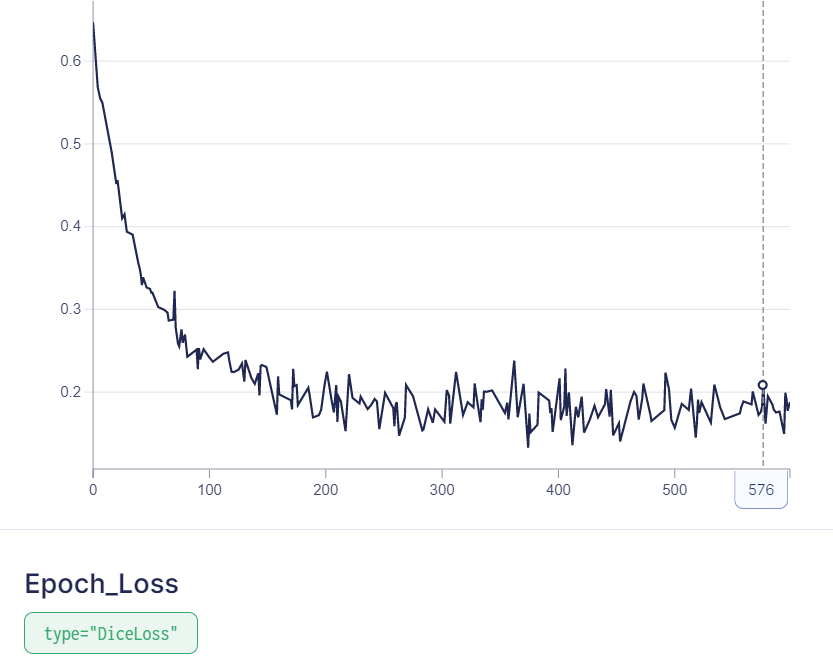
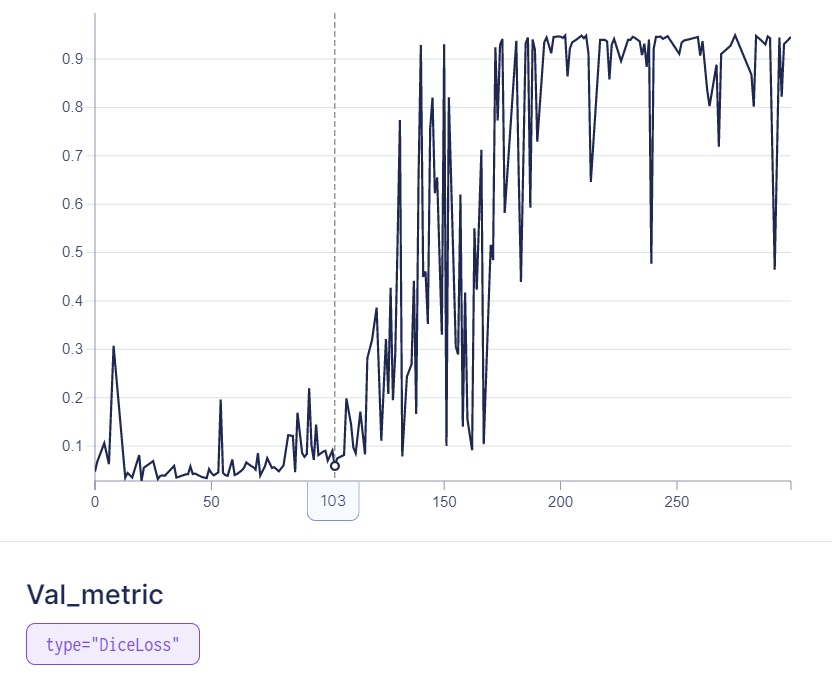

## Cleanup data directory

Remove directory if a temporary was used.

In [ ]:
if directory is None:
    shutil.rmtree(root_dir)